# Microtask: Explore Toolhub Data

## Introduction

[Toolhub](https://toolhub.wikimedia.org/) is a community-authored catalog containing 2.600+ Wikimedia tools. Technical volunteers can use Toolhub to document the tools that they create or maintain. All Wikimedians can use Toolhub to search for tools to help with their workflows and to create lists of useful tools to share with others.

In Toolhub, "tool" is an inclusive term for software applications which interact with the Wikimedia projects without being fully implemented by MediaWiki. This includes things like user scripts, gadgets, bots, templates, lua modules, web applications, and mobile apps. The catalog is intended to be inclusive rather than exclusive as long as the things it documents are useful for improving workflows and user experiences when interacting with the projects of the Wikimedia movement.

You can [read more about Toolhub on Meta Wiki](https://meta.wikimedia.org/wiki/Toolhub). You are also encouraged to explore [Toolhub's demo server](https://toolhub-demo.wmcloud.org/). Among other things, you can use it to search for tools, and create and edit your own; understanding what info is available about tools, and how it's added, edited, and displayed can help you with the tasks in this notebook. You can consider the demo server as a sandbox where you can play and explore without worrying that anything could break. 

If you click on any one tool, you will see information about it displayed. Example: [Wikidata Todo](https://toolhub.wikimedia.org/tools/mm_wikidata_todo). This information is submitted by the tool's maintainer(s) in a `toolinfo.json` file, which contains a lot of different fields; however, most of them are optional, and for this reason, much potentially useful information is missing. Missing tool information lowers Toolhub's quality as a whole, and makes tools less discoverable by the site's search and filtering functionalities. 

The good news is, some of the information contained in the toolinfo record is editable by anyone (as long as they are logged in) by clicking the "edit tool" button on the tool info page, or via the [Toolhub API](https://toolhub.wikimedia.org/api-docs). 

The aim of this Outreachy project is to create a dedicated web application for editing Toolhub records in a fun and easy way, similar to how the tool [Citation Hunt](https://citationhunt.toolforge.org/en?id=938f63ed) improves the experience of adding missing sources to Wikipedia articles. Feel free to create and edit your own "fake tools" using the demo server. This might help you understand the workflows our app will attempt to improve. 

This web application will include the following features:

* An interface for completing tasks
* A leaderboard
* Stretch goal: a dashboard, showing toolinfo completeness statistics

## Working with the Toolhub API

Using the link in the previous section, navigate to the Toolhub API docs. There are many different endpoints, grouped by functionality. Most of these will not be relevant to this project, for instance "autocomplete", "crawler", or "spdx". These, and many others, can be safely ignored.

This is an example of how to retrieve the info for a given tool.

In [1]:
import json  # will let us print out the response in a prettier format
import requests  # necessary to make API calls
import datetime # for Task #2
import functools as ft
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import collections

# configure API session parameters

# user_agent helps identify the request if there is an issue and is best practice
REQUEST_LABEL = 'Outreachy 25 Toolhub Microtask'

# NOTE: it's considered best practice to include contact info in user agents
USER_INFO = 'Phabricator user: NicoleLBee'

headers = {'User-Agent': f'{REQUEST_LABEL} - {USER_INFO}'}

TOOLS_API_ENDPOINT = "https://toolhub.wikimedia.org/api/tools"
toolname = "pywikibot"
url = f'{TOOLS_API_ENDPOINT}/{toolname}/'

#response = requests.get(url, headers=headers)
#if response.status_code == 200:
#    json_formatted_response = json.dumps(response.json(), indent=2)
#    print(json_formatted_response)
#else:
#    print(response.status_code)

There's quite a lot of data here! This might be a good moment for you to get familiar with the [Toolhub Data Model](https://meta.wikimedia.org/wiki/Toolhub/Data_model).

The data we are interested in is the `annotations` dict. This is the data that anyone can edit. However, if you look closely, you will see that some of the fields in "annotations", are actually present elsewhere in the data too. For instance, "repository" exists both as a top-level key, and as a key in the nested "annotations" dict. The reason for this is that Toolhub features two "layers" of tool info: The "Core" toolinfo, and the "Annotations" toolinfo.

* The **Core** tool info is the info provided by a tools maintainer(s), by way of the `toolinfo.json` file. This info is considered the ultimate source of truth, and cannot be overwritten by someone else by editing the tool.
* **Annotations** provide a way for anyone to add missing info to a tool. However, this information will be displayed *if and only if* the corresponding piece of information is missing in the Core info layer. Some fields, like for example `wikidata_qid`, exist only in the Annotations layer.
* Note that the **Core** tool info is not explicitely called "Core" in the json response from the API. You can think of all the fields that *aren't* part of the `annotations` dict as being the "Core info"

You can find some more information about Core vs Annotations in [Toolhub docs: Editing Tool info](https://meta.wikimedia.org/wiki/Toolhub#Editing_tool_info).

The conclusion is that we will consider a piece of information missing only if it is absent from both the Core *and* Annotations layers. 

## Tasks

For each of the tasks that follow, whenever you write a function, you should also write **one or more tests**, to convince yourself and the readers of this notebook that it does what it is supposed to do.

Don't get discouraged if you get stuck – you can always ask the mentors and other applicants for help in Phabricator.

**NOTE:** Many Python libraries are already available in PAWS; should you need any that isn't, you can easily install it by running `!pip install <library-name>` in a code cell.

### Task set 1

In [2]:
# TODO: Write a function that takes a tool name,
# and returns all the missing fields as a list.

def list_missing_fields(target):
    url = f'{TOOLS_API_ENDPOINT}/{target}/'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        api_response = response.json()
        empty_fields = []
        for key in api_response["annotations"]:
            # If the tool has not been deprecated, then the absence of a value for "replaced_by" is irrelevant
            if key == "replaced_by" and (api_response["deprecated"] == False or api_response["annotations"]["deprecated"] == False):
                 continue
            # Although the following lines are unwieldy, it was specified that a piece of information is missing only if it is absent in both the Core and Annotations layers, and therefore I need to check both sources.
            # This only works if the key exists in both places, so I check for that first.
            elif (key in api_response):
                    if (api_response[key] == [] or api_response[key] == None) and (api_response["annotations"][key] == [] or api_response["annotations"][key] == None):
                        empty_fields.append(key)
            elif api_response["annotations"][key] == [] or api_response["annotations"][key] == None:
                empty_fields.append(key)
        return empty_fields
    else:
        print(response.status_code)


 **TESTING TASK 1**:  

Examining the output of the fetch request in the example code block, I can see that, within the "annotations" dict of pywikibot, the following fields have no value:
 ```
    "wikidata_qid": null,
    "replaced_by": null,
    "for_wikis": [],
    "icon": null,
    "tool_type": null,
    "repository": null,
    "api_url": null,
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": null,
    "bugtracker_url": null
```

However, most of these have values contained within the Core tool info.  If I eliminate the ones that are assigned values in the Core tool info, and eliminate "replaced_by" (since the tool is not deprecated, the absence of a value here is expected), I'm left with the following empty fields:

```
wikidata_qid  
api_url  
feedback_url  
privacy_policy_url
```

So I would expect that calling `list_missing_fields("pywikibot")` would return the following list: `['wikidata_quid', 'api_url', 'feedback_url', 'privacy_policy_url']`

In [3]:
list_missing_fields("pywikibot")

['wikidata_qid', 'api_url', 'feedback_url', 'privacy_policy_url']

I'll try another: `mm_wikidata_todo`  When I plug the toolname into the code block found at the beginning of the document, I can see that the following fields in the "annotations" dict have no value:  

```
  "annotations": {
    "wikidata_qid": null,
    "replaced_by": null,
    "for_wikis": [],
    "icon": null,
    "api_url": null,
    "developer_docs_url": [],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": null,
  },
  ```

Checking against the relevant Core values, 

```
 "deprecated": false,
  "replaced_by": null,
  "experimental": false,
  "for_wikis": [],
  "icon": null,
  "license": null,
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [],
  "tool_type": null,
  "api_url": null,
  "developer_docs_url": [],
  "user_docs_url": [],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": null,
  "bugtracker_url": null,
  ```
  
  And I can see that the following fields have no value in either Annotations or the Core:
  ```
  wikidata_qid,
  replaced_by,
  for_wikis,
  icon,
  api_url,
  developer_docs_url,
  user_docs_url,
  feedback_url,
  privacy_policy_url,
  translate_url
  ```
  
  Considering that my function would eliminate `replaced_by`,  I would expect that `list_missing_fields("mm_wikidata_todo")` would return the following list:
  
  ```
  [ 'wikidata_qid',
  'for_wikis',
  'icon',
  'api_url',
  'developer_docs_url',
  'user_docs_url',
  'feedback_url',
  'privacy_policy_url',
  'translate_url' ]
  ```

In [4]:
list_missing_fields("mm_wikidata_todo")

['wikidata_qid',
 'for_wikis',
 'icon',
 'api_url',
 'user_docs_url',
 'feedback_url',
 'privacy_policy_url',
 'translate_url']

**TODO**: Consider all the fields that are editable.
1. Should they all be considered equally valuable from the point of view of a user searching for a tool to use in their workflows?
2. Or a user that is looking for a tool to contribute to? Why or why not?
3. Which are, according to you, the three most valuable fields? Which are the least valuable? Explain your reasoning.

1. In my opinion, they would not be equally valuable from the PoV of a user searching for a tool to use.  A user who wants to make use of a tool would be most interested in the context in which the tool would be used (i.e., "tool_type") or in documentation pertaining to the tool's use (e.g., "user_docs_url").

2. On the other hand, a user who was looking to make a contribution wouldbe more interested in the "repository," "developer_docs_url," "bug_tracker_url" fields.  Users will naturally look for information that will assist them in achieving their goal, so naturally users with different goals (in this case, working *with* a tool vs. working *on* a tool) will be interested in different pieces of information.

3. I would like include "replaced_by" in both the most **and** least valuable lists, simply because if the tool isn't depreciated, then the value of the field is of no importance whatsoever, but if the tool **is** depreciated, then it is **extremely** important.  (I know I keep banging on about this field.)  

Least valuable:  icon (purely cosmetic, contains no useful information either for a user or a contributor), replaced_by (in the event that the 

## How much info is missing? 

So far, we have only called the `/api/tools/{toolname}/` endpoint, which gives us one tool at a time. But we can also request *all* the tools, using another of the available endpoints.

### Task set 2

In [5]:
# TODO: Write a function that returns a dict where the keys are tool names, and the values are tuples:
# {<tool name>: (<number of missing fields>, <days since the tool was last edited>)}.

# Make a request to the /api/tools endpoint, gather the values from the "results" dict: for each entry, "name"  and "modified_date" (OR "created_date", if it's never been modified
# Run it through a modified version of the the function that I wrote above and return the length of the dict to fill the <number of missing fields> bit
# Push all of that info to an entry in the dict.

# First I will rewrite the above function to serve as a callback function.  This time it will only return the length of the list, e.g. the number of empty fields.

def countMissingEntries(entry):
    empty_fields = []
    for key in entry["annotations"]:
        if key == "replaced_by" and (entry["deprecated"] == False or entry["annotations"]["deprecated"] == False):
            continue
        elif (key in entry):
            if (entry[key] == [] or entry[key] == None) and (entry["annotations"][key] == [] or entry["annotations"][key] == None):
                        empty_fields.append(key)
        elif entry["annotations"][key] == [] or entry["annotations"][key] == None:
             empty_fields.append(key)
    return len(empty_fields)
    
# The value of the "modified_date" and "created_date" fields does not appear to be in iso format, or at least datetime.date.fromisoformat doesn't want to recognize it
# What a bummer!  So I'll write a function to make a proper date out of the value.  I only need the year, month and day.

def parseDate(date):
    slice_point = date.index('T')
    year, month, day = date[0:slice_point].split('-')
    return datetime.date(int(year), int(month), int(day))

# I'll write another function to calculate the number of days elapsed between the current date and the value of the "modified_date" field

def calculateDaysElapsed(entry_date): 
    current_date = datetime.date.today()
    past_date = parseDate(entry_date)
    return (current_date - past_date).days

# Then I will write a cut-down version of the function to ensure that it will produce the results that I want using a test data set and those functions I just wrote.

def listToolsTest(target):
    tool_entries = {}
    data_set = target["results"]
    for entry in data_set:
        # I want to calculate days elapsed based on the value of "modified_date" if it exists and the value of "created_date" if it does not.
        date = entry["modified_date"] or entry["created_date"]
        tool_entries[entry["name"]] = (countMissingEntries(entry), calculateDaysElapsed(date))
    return tool_entries     

## Testing the function(s) ##

I'll test the core functionality by taking information from the following dict, which is structured in the same way as the result of an actual fetch request to the /api/tools endpoint, and contains the data from "mm_wikidata_todo" and "pywikibot" plus a modified dataset that 
contains no modified date.

In [6]:
mock_data = {
    "count": 2702,
    "next": "https://toolhub.wikimedia.org/api/search/tools/?page=2",
    "previous": None,
    "results": [
{
      "name": "mm_wikidata_todo",
      "title": "Wikidata Todo",
      "description": "Shows you little things you can do on Wikidata.",
      "url": "http://tools.wmflabs.org/wikidata-todo",
      "keywords": [
        "wikidata",
        "task"
      ],
      "author": [
        {
          "name": "Magnus Manske"
        }
      ],
      "repository": "https://bitbucket.org/magnusmanske/wikidata-todo",
      "subtitle": None,
      "openhub_id": None,
      "url_alternates": [],
      "bot_username": None,
      "deprecated": False,
      "replaced_by": None,
      "experimental": False,
      "for_wikis": [],
      "icon": None,
      "license": None,
      "sponsor": [],
      "available_ui_languages": [],
      "technology_used": [],
      "tool_type": None,
      "api_url": None,
      "developer_docs_url": [],
      "user_docs_url": [],
      "feedback_url": [],
      "privacy_policy_url": [],
      "translate_url": None,
      "bugtracker_url": None,
      "annotations": {
        "wikidata_qid": None,
        "deprecated": False,
        "replaced_by": None,
        "experimental": False,
        "for_wikis": [],
        "icon": None,
        "available_ui_languages": [
          "en"
        ],
        "tool_type": "web app",
        "repository": "https://bitbucket.org/magnusmanske/wikidata-todo/src/master/",
        "api_url": None,
        "developer_docs_url": [
          {
            "url": "https://toolhub.mediawiki.com",
            "language": "en"
          }
        ],
        "user_docs_url": [],
        "feedback_url": [],
        "privacy_policy_url": [],
        "translate_url": None,
        "bugtracker_url": "https://bitbucket.org/magnusmanske/wikidata-todo/issues?status=new&status=open"
      },
      "_schema": None,
      "_language": "en",
      "origin": "crawler",
      "created_by": {
        "id": 9,
        "username": "Toolhub"
      },
      "created_date": "2021-10-10T21:04:18.627185Z",
      "modified_by": {
        "id": 428,
        "username": "Sabina.zaripova"
      },
      "modified_date": "2022-10-16T10:02:45.287384Z"
    },
        
    {
  "name": "pywikibot",
  "title": "Pywikibot",
  "description": "Python library and collection of scripts that automate work on MediaWiki sites",
  "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
  "keywords": [],
  "author": [
    {
      "name": "Pywikibot team"
    }
  ],
  "repository": "https://gerrit.wikimedia.org/g/pywikibot/core",
  "subtitle": None,
  "openhub_id": None,
  "url_alternates": [],
  "bot_username": None,
  "deprecated": False,
  "replaced_by": None,
  "experimental": False,
  "for_wikis": [
    "*"
  ],
  "icon": "https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg",
  "license": "MIT",
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [
    "python"
  ],
  "tool_type": "coding framework",
  "api_url": None,
  "developer_docs_url": [
    {
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development",
      "language": "en"
    }
  ],
  "user_docs_url": [
    {
      "language": "en",
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot"
    },
    {
      "url": "https://doc.wikimedia.org/pywikibot/",
      "language": "en"
    }
  ],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": "https://translatewiki.net/wiki/Translating:Pywikibot",
  "bugtracker_url": "https://phabricator.wikimedia.org/tag/pywikibot/",
  "annotations": {
    "wikidata_qid": None,
    "deprecated": False,
    "replaced_by": None,
    "experimental": False,
    "for_wikis": [],
    "icon": None,
    "available_ui_languages": [
      "en"
    ],
    "tool_type": None,
    "repository": None,
    "api_url": None,
    "developer_docs_url": [
      {
        "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
        "language": "en"
      }
    ],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": None,
    "bugtracker_url": None
  },
  "_schema": None,
  "_language": "en",
  "origin": "api",
  "created_by": {
    "id": 10,
    "username": "JJMC89"
  },
  "created_date": "2021-10-12T20:26:29.012245Z",
  "modified_by": {
    "id": 3,
    "username": "BDavis (WMF)"
  },
  "modified_date": "2022-05-21T17:22:54.441791Z"
},
            {
  "name": "pywikifake",
  "title": "Pywikibot",
  "description": "Python library and collection of scripts that automate work on MediaWiki sites",
  "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
  "keywords": [],
  "author": [
    {
      "name": "Pywikibot team"
    }
  ],
  "repository": "https://gerrit.wikimedia.org/g/pywikibot/core",
  "subtitle": None,
  "openhub_id": None,
  "url_alternates": [],
  "bot_username": None,
  "deprecated": False,
  "replaced_by": None,
  "experimental": False,
  "for_wikis": [
    "*"
  ],
  "icon": "https://commons.wikimedia.org/wiki/File:Pywikibot_MW_gear_icon.svg",
  "license": "MIT",
  "sponsor": [],
  "available_ui_languages": [],
  "technology_used": [
    "python"
  ],
  "tool_type": "coding framework",
  "api_url": None,
  "developer_docs_url": [
    {
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot/Development",
      "language": "en"
    }
  ],
  "user_docs_url": [
    {
      "language": "en",
      "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot"
    },
    {
      "url": "https://doc.wikimedia.org/pywikibot/",
      "language": "en"
    }
  ],
  "feedback_url": [],
  "privacy_policy_url": [],
  "translate_url": "https://translatewiki.net/wiki/Translating:Pywikibot",
  "bugtracker_url": "https://phabricator.wikimedia.org/tag/pywikibot/",
  "annotations": {
    "wikidata_qid": None,
    "deprecated": False,
    "replaced_by": None,
    "experimental": False,
    "for_wikis": [],
    "icon": None,
    "available_ui_languages": [
      "en"
    ],
    "tool_type": None,
    "repository": None,
    "api_url": None,
    "developer_docs_url": [
      {
        "url": "https://www.mediawiki.org/wiki/Special:MyLanguage/Manual:Pywikibot",
        "language": "en"
      }
    ],
    "user_docs_url": [],
    "feedback_url": [],
    "privacy_policy_url": [],
    "translate_url": None,
    "bugtracker_url": None
  },
  "_schema": None,
  "_language": "en",
  "origin": "api",
  "created_by": {
    "id": 10,
    "username": "JJMC89"
  },
  "created_date": "2021-10-12T20:26:29.012245Z",
  "modified_by": None,
  "modified_date": None
}
    ]
}

I already know that "mm_wikidata_todo" has 8 missing fields, and "pywikibot" has 4.
Looking at the dates, I can see that "mm_wikidata_todo" was last modified on October 16, 2022.  "pywikibot" was modified on May 21, 2022 and created on October 12, 2021.  (The creation date is what should be referenced in the third entry of the list, as I have deliberately removed the value of "modified_date".)

Therefore, based on today being October 17th, I would expect `listToolsTest(mock_data)` to return the following:
```
{
    'mm_wikidata_todo': (8, 1),
    'pywikibot': (4, 149),
    'pywikifake': (4, 370)
 }
```

The estimated dates will be a little off by the time you see this!

In [7]:
listToolsTest(mock_data)

{'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371)}

In [8]:
# As I am satisfied that my function is working properly, I can incorporate the actual fetch request.

def buildToolDict():
    url = f'{TOOLS_API_ENDPOINT}'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        api_response = response.json()
        tools = api_response["results"]
        while api_response["next"]:
            api_response = requests.get(api_response["next"], headers=headers).json()
            tools.extend(api_response["results"])
        tool_entries = {}
        for entry in tools:
            date = entry["modified_date"] or entry["created_date"]
            tool_entries[entry["name"]] = (countMissingEntries(entry), calculateDaysElapsed(date))
        return tool_entries
    else:
        print(response.status_code)

# I tested this function by setting the return value to len(tool_entries) and received a value of 2702, which is equal to the maximum count of documents that I received while playing with the API
# Therefore, I am confident that the function is functioning.

In [9]:
# TODO: Visualize this data in a meaningful way. 
# You can install and/or import any Python libraries you think will be useful.
# Feel free to use other fields and/or create additional visualizations!

I decided that I would like to create a visualization to represent how many tools are missing fields: as in, how many tools are missing just 1 field, or 2 fields, etc.  Are many tools missing fields?

For that, I decided to iterate over the results of `buildToolDict()` and determine how many times certain values appear in `<number of missing fields>`

My first step was to build a function that I could test, using the tiny data set and listToolsTest()

I want the function to return the data in a sorted dictionary, from fewest tools missing to most tools missing.

In [10]:
def dataToDict(data):
    data_plot = {}
    for key, value in data.items():
        new_key = value[0]
        if new_key in data_plot:
            data_plot[new_key] += 1
        else:
            data_plot[new_key] = 1
    return dict(sorted(data_plot.items()))

I already know that `listToolsTest(mock_data)` will return the following:
```
{'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371)}
```

One tool is missing eight items, and two tools are missing 4 items.  Therefore I would expect that passing that dict into `dataToDict()` would give me the following result: `{4: 2, 8: 1}`

I also wanted a second test, so wrote another dummy dict.

In [11]:
test1 = {'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371)}
test2 = {'mm_wikidata_todo': (8, 2), 'pywikibot': (4, 150), 'pywikifake': (4, 371), 'mm_wikidata_todo2': (3, 2), 'pywikibot2': (4, 150), 'pywikifake2': (4, 371)}
print(dataToDict(test1))  # I expect to see {4: 2, 8: 1}
print(dataToDict(test2)) # I expect to see {3: 1, 4: 4, 8: 1}


{4: 2, 8: 1}
{3: 1, 4: 4, 8: 1}


In [12]:
# Let's tie it all together with the output from buildToolDict()

entries = buildToolDict()
plottable_data = dataToDict(entries)
print(plottable_data)

{0: 1, 1: 1, 3: 7, 4: 6, 5: 10, 6: 23, 7: 32, 8: 69, 9: 89, 10: 109, 11: 759, 12: 451, 13: 1145}


Text(0, 0.5, 'Tools')

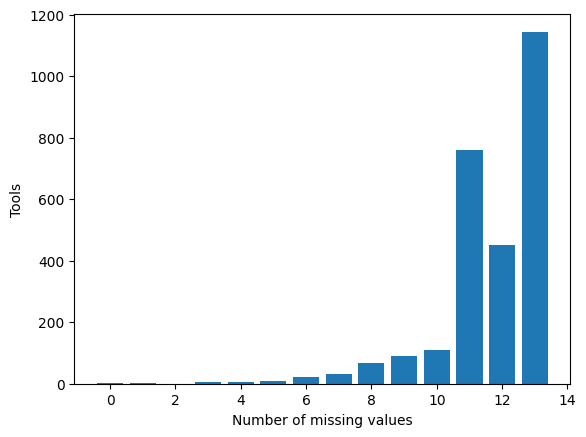

In [13]:
# Fabulous!  Now I can finally visualize the data!  

plt.bar(plottable_data.keys(), plottable_data.values())
plt.xlabel('Number of missing values')
plt.ylabel('Number of tools')


In [14]:
# TODO: Which fields are most frequently missing? 

# Push the results of the function calls (the dicts with the list of missing fields) to another dict and then look for the Pythonic version of "reduce" to do the thing that I can do in JS
# That will give me a tally of missing fields.
# I will do that as part of the above visualization

Another way to find tools with missing info is via the "missing" facet in search results. 

* This link will take you to a page with search results corresponding to a search for "all the tools" https://toolhub.wikimedia.org/search?ordering=-score&page=1&page_size=12
* Observe the left side of the screen, where there is a list of search facets. The first is called "Tool type", and you can see that there are 1600+ tools missing this info
* This "missing" facet can be retrieved from the `/api/search/tools` endpoint. Go back to the [API docs](https://toolhub.wikimedia.org/api-docs), and play around with this endpoint until you feel you understand it. You can also perform various searches in Toolhub, each time observing the results you get, and the query parameters in your browser's search bar. Similarly, if you are comfortable with your browser's developer tools, you can use these to observe the HTTP requests and responses.

### Task set 3

In [15]:
# TODO: Just as in task set 1, write a function that takes a tool name,
# and returns all the missing fields as a list. However this time,
# use the /api/search/tools endpoint.

# According to you, which of the two endpoints is most suitable
# for retrieving missing records, and why? 

## Implementation details

The web application will present users with small tasks, such as "This tool is missing a link to its source code, can you find one?" These tasks will be sourced from a task queue, in which the tasks are ideally ordered from most to least "important".

**TODO**: Reflect on the following questions, and try to answer them to the best of your ability. These are open-ended questions and there's likely more than one good way to do things. Explaining your reasoning and discussing the pros and cons of different approaches is more important than arriving at the "right" answer.

### Task set 4

1. How should we define "important"? In other words, according to what criteria do you think priority in the task queue should be established?
2. The user should have the option to skip a task and move on to the next one. A reason for skipping could be that the user tried to find the requested information, but failed. Do you think we should gather this information, for instance by having the user check a box indicating their "skip reason" before being able to click skip? What other possible skip reasons could you think of. Could this information be useful when deciding which tasks to show to which users, when to show a given task again, etc.?
3. If more than one user is connected to the application and working on tasks at the same time, how would you make sure they are not presented with the same tasks?